# Introduction

The Purpose of this project is to predict win probability in Valorant Esports using various scikitlearn ML algorithms, identifying the best one. I had attempted to predict win probability in the past using simple linear regression in Excel, and I would like to improve on that process and enhance profitability. I will be comparing my old linear regression model versus a Neural Network, GradientBoostingRegressor, XGBoost, and a model combining the 3. If successful, I could try something similar with more mainstream sports with higher betting limits.

# Data sources and analysis

All valorant statistics are scraped from vlr.gg, a site that has access to the Riot Games API (Valorant developer) for competitive esports match statistics. I have code from the past where I use selenium and beautifulsoup to extract text from website elements, and pandas to organize this scraped data and save match stats/economy data to .csvs.

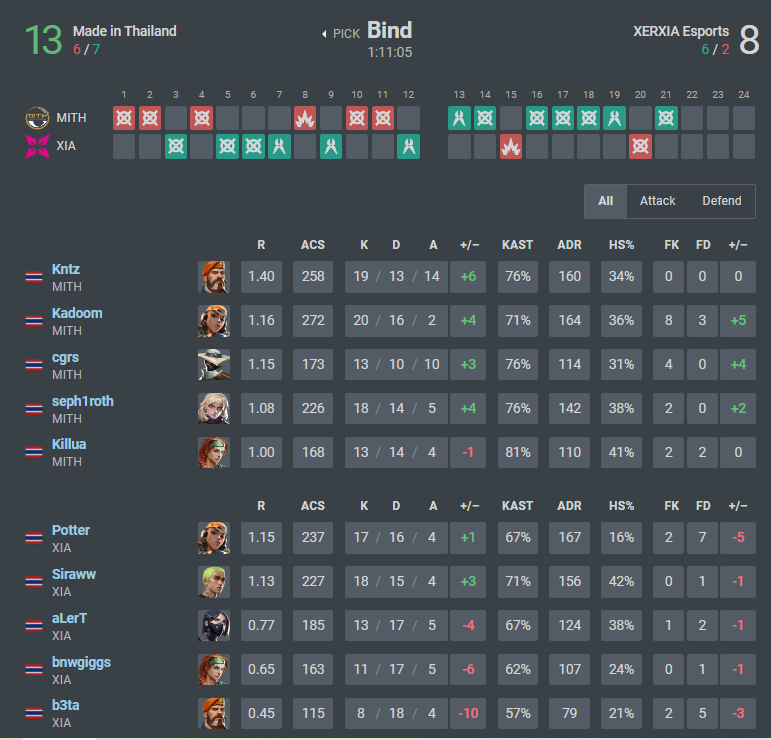
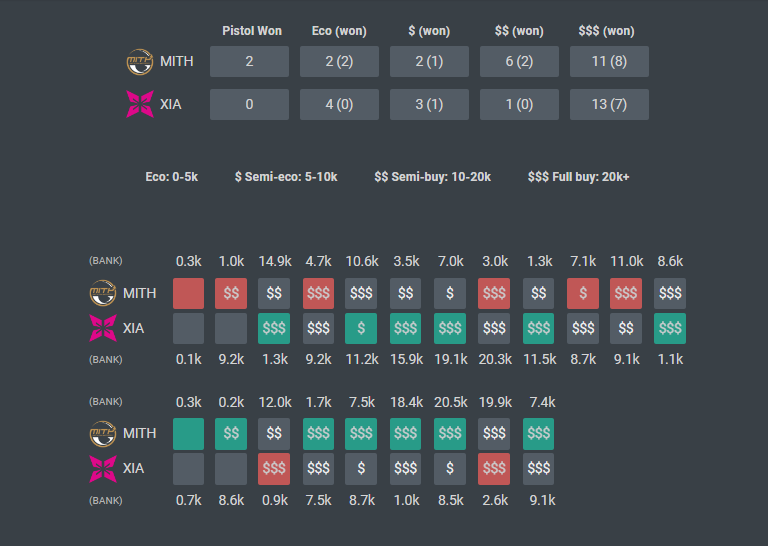


The efficiency of this process could probably be improved upon, but I import the .csvs to excel, and mass clean inevitable web scraping data errors with power query. Various formulas are used to aggregate statistics by team for each match

# Methodology

To predict win probability for teams in valorant, I am using round differential (essentially margin of victory) as my dependent variable, and various match statistics as predictors. I make a round differential prediction for a potential best of one series between 2 teams, and then use the binomial distibution to adjust this percentage if the series is longer at 3 or 5 games. I then compare my win probability prediction to decimal betting odds, which I then compare to betting odds on thunderpick.gg. Stake is determined with kelly staking, which calculates the optimal bet size by subtracting the fraction of your capital that you would lose if you lost the bet from the fraction you would gain if you won, adjusted for the odds and probability of winning. I am using $250 as my maximum stake, so 250* kelly would equal the amount I'd put down. Beyond this, I am capping maximum stake at 75 dollars, or 0.3 kelly. I am skeptical of very large kelly suggestions, as this is likely indicative of the fact my model is missing something.

With many statistics to choose from, I tried to be as calculated as possible when initially narrowing them down. I first looked at statistics that had at least a 55% correlation to positive round differential (winning a game) which eliminated lots of metrics. Feeding a large quantity of variables into excel regression allowed me to see additional variables that made very marginal impacts, as well as variables with p values above 0.05 (not statistically significant). Some of the strongest predictors were statistics related to round win rate in different contexts (win rates when attacking, defending, win rates with different levels of economy relative to opponent). While standard error decreased with all of these win rates fed into the model, it seemed abundantly clear that there would be a high level of multicollinearity between these variables. I decided to go with economic win rates over attack/defense win rates as inputs into the model. There are various reasons for this, but a primary one was that attack/defense win rates had almost identical impacts on round differential, and having simply win rate as an input in the model without much other context didn't make as much sense to me as having win rates with an economic context.

I have thousands of matches worth of information scraped from past valorant matches dating back to July 2023. With various evaluation metrics such as Multiple R, R Square, Adjusted R Square, and Standard error all improving in my basic excel linear regression model while using this data vs recent match data, it seems logical to use all this historical data for training the models. For making predictions in the present, I am careful to use data from only the more recent patches, as character strength and maps in the competitive rotation change over time, which benefits some teams and hurts others based on the strengths of the players. Additional, If a team makes a change to their roster I wouldn't make a prediction involving said team until they reach a reasonably large sample size with their new iteration (I've defined this at 100 rounds).

# Predictive technique selection explained

Having experimented with linear regression before, I was excited for the opportunity to try another method of making predictions via a neural network and learn something new. While my linear regression model was profitable, it had a tendency to overvalue underdogs, and I am curious about what the extent of the difference between these different models might look like. As valorant is a complicated game with various statistics related to game state that have an impact on winning, using a neural network could prove more accurate when dealing with these complicated relationships that may not always be linear. 

GradientBoostingRegressor and XGBoost I am also intrigued by as more machine-learning predictive algorithms I can throw at the data to see if one rises to the top in terms of profitability. GradientBoostingRegressor I had looked at in the past, and I had similar concerns to the basic linear regression model that it would overvalue favorites. Similar to linear regression, this model aims to minimize the prediction error, but unlike linear regression, it does so by combining multiple decision trees in a sequential manner to capture complex, non-linear relationships and improve accuracy through boosting. XGBoost was nice to add as contrasting method. It relies on sequential decision tree aggregation, but uses regularization to deal with overfitting/complexity and column subsampling to reduce variance. 

At the hyperparameter level, I used GridSearchCV to systematically identify the parameters that resulted in the lowest possible test RMSE for each model. I experimented with automating selection with Optuna, but I wasn't satisfied with the results. While my GBR parameters stayed the same as the sample of games increased, this was not the case with the NN and XGB. RMSE for these models increased notably, but I was able to lower test RMSE primarily with increases in Epochs/Estimators. This will be something I monitor going forward.

In [45]:
#GradientBoostingRegressor

import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\scikit_2.csv")

# Define features and target
features = ['Odds', 'Gun Round W%', 'Even Buy W%', 'Eco W%', 'Adv Buy W%', 'Rating', 'PM', 'Odds2',
             'Gun Round W%2', 'Even Buy W%2', 'Eco W%2', 'Adv Buy W%2', 'Rating2', 'PM2']
df_without_missing_values = df.dropna()
target = df_without_missing_values['Round Differential']
X = df_without_missing_values[features]
y = target

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

# Define fixed hyperparameters
fixed_params = {
    'n_estimators': 320,  
    'learning_rate': 0.12,      
    'max_depth': 4,  
    'min_samples_split': 8,  
    'min_samples_leaf': 4    
}
# Define the GradientBoostingRegressor model with fixed parameters
gbr_model = GradientBoostingRegressor(random_state=42, **fixed_params)

# Train the model
gbr_model.fit(X_train, y_train)

# Predictions with the model
gbr_predict_train = gbr_model.predict(X_train)
gbr_predict_test = gbr_model.predict(X_test)

# RMSE and R² for Gradient Boosting Regressor
RMSE_gbr_train = sqrt(mean_squared_error(y_train, gbr_predict_train))
RMSE_gbr_test = sqrt(mean_squared_error(y_test, gbr_predict_test))
R2_gbr_train = r2_score(y_train, gbr_predict_train)
R2_gbr_test = r2_score(y_test, gbr_predict_test)

print(f"RMSE (training) for GBR: {RMSE_gbr_train:.10f}")
print(f"RMSE (test) for GBR: {RMSE_gbr_test:.10f}")
print(f"R² (training) for GBR: {R2_gbr_train:.10f}")
print(f"R² (test) for GBR: {R2_gbr_test:.10f}")

# Load the new data for prediction
Bet = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\Upcoming_val.csv")

# Ensure Bet data has the same features as the training data
Bet = Bet[features]  # Ensure columns are in the correct order
Bet_scaled = scaler.transform(Bet)

# Predict using the Gradient Boosting model
GB_predict_tonight = gbr_model.predict(Bet_scaled)
Tonights_Totals_GB = pd.DataFrame(GB_predict_tonight, columns=['Round Diff'])

print("Predictions using Gradient Boosting:")
print(Tonights_Totals_GB.to_string(index=False))

RMSE (training) for GBR: 0.4061290137
RMSE (test) for GBR: 0.9024496424
R² (training) for GBR: 0.9927052602
R² (test) for GBR: 0.9673889483
Predictions using Gradient Boosting:
 Round Diff
   2.693622
   0.584211
   1.463387


In [19]:
#Neural Network

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

np.random.seed(456)
tf.random.set_seed(456)

# Register the swish activation function
@tf.keras.utils.register_keras_serializable()
def swish(x):
    return tf.nn.swish(x)

# Load the data
df = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\scikit_2.csv")

# Define features and target
features = ['Odds', 'Gun Round W%', 'Even Buy W%', 'Eco W%', 'Adv Buy W%', 'Rating', 'PM', 'Odds2',
             'Gun Round W%2', 'Even Buy W%2', 'Eco W%2', 'Adv Buy W%2', 'Rating2', 'PM2']
df_without_missing_values = df.dropna()
target = df_without_missing_values['Round Differential']
X = df_without_missing_values[features]
y = target

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

# Fixed parameters
epochs = 225
dropout_rate = 0.07
batch_size = 150
learning_rate = 0.001  

def create_nn_model(layer_config, learning_rate):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Ensure input shape matches number of features

    # Add layers according to configuration
    model.add(Dense(layer_config[0]['units'], kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    if layer_config[0].get('batch_norm', False):
        model.add(BatchNormalization())
    
    model.add(tf.keras.layers.Activation(swish))
    
    if layer_config[0].get('dropout', 0) > 0:
        model.add(Dropout(layer_config[0]['dropout']))
    
    for layer in layer_config[1:]:
        model.add(Dense(layer['units'], kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        if layer.get('batch_norm', False):
            model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation(swish))
        if layer.get('dropout', 0) > 0:
            model.add(Dropout(layer['dropout']))
    
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define layer configuration
layer_config = [{'units': 160, 'dropout': dropout_rate},
                {'units': 70, 'batch_norm': True, 'dropout': dropout_rate},
                {'units': 30}]

# Train the final Neural Network model on the entire training set using the best learning rate
final_model = create_nn_model(layer_config, learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('neural_network_model.keras', save_best_only=True)
final_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,
                callbacks=[early_stopping, model_checkpoint], verbose=1)

# Load the final best model
best_model = load_model('neural_network_model.keras', custom_objects={'swish': swish})

# Predict and evaluate on training and test data
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# RMSE and R² for Neural Network
RMSE_nn_train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_nn_test = sqrt(mean_squared_error(y_test, y_test_pred))
R2_nn_train = r2_score(y_train, y_train_pred)
R2_nn_test = r2_score(y_test, y_test_pred)

print(f"RMSE (training) for NN: {RMSE_nn_train:.10f}")
print(f"RMSE (test) for NN: {RMSE_nn_test:.10f}")
print(f"R² (training) for NN: {R2_nn_train:.10f}")
print(f"R² (test) for NN: {R2_nn_test:.10f}")

# Load the new data for prediction
Bet = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\Upcoming_val.csv")

# Ensure Bet data has the same features as the training data
Bet = Bet[features]  # Ensure columns are in the correct order
Bet_scaled = scaler.transform(Bet)

# Predict using the Neural Network model
Bet_predictions_nn = best_model.predict(Bet_scaled)
Tonights_Totals_NN = pd.DataFrame(Bet_predictions_nn, columns=['Round Diff'])

print("Predictions using Neural Network:")
print(Tonights_Totals_NN.to_string(index=False))

Epoch 1/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 26.4943 - val_loss: 26.7216
Epoch 2/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.2499 - val_loss: 20.1250
Epoch 3/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4225 - val_loss: 16.4517
Epoch 4/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0305 - val_loss: 15.0310
Epoch 5/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7198 - val_loss: 13.4998
Epoch 6/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0770 - val_loss: 11.9497
Epoch 7/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9098 - val_loss: 10.5798
Epoch 8/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8561 - val_loss: 9.2395
Epoch 9/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7302 - val_loss: 8.2780
Epoch 10/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6754 - val_loss: 7.1535
Epoch 11/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6337 - val_loss: 6.2939
Epoch 12/225
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step -

In [2]:
#Stacking Model

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from math import sqrt

np.random.seed(456)
tf.random.set_seed(456)

# Register the swish activation function
@tf.keras.utils.register_keras_serializable()
def swish(x):
    return tf.nn.swish(x)

# Load the data
df = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\scikit_2.csv")

# Define features and target
features = ['Odds', 'Gun Round W%', 'Even Buy W%', 'Eco W%', 'Adv Buy W%', 'Rating', 'PM', 'Odds2',
             'Gun Round W%2', 'Even Buy W%2', 'Eco W%2', 'Adv Buy W%2', 'Rating2', 'PM2']
df_without_missing_values = df.dropna()
target = df_without_missing_values['Round Differential']
X = df_without_missing_values[features]
y = target

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

# Fixed parameters
epochs = 225
dropout_rate = 0.07
learning_rate = 0.001
batch_size = 150

def create_nn_model(layer_config):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))

    # Add layers according to configuration
    model.add(Dense(layer_config[0]['units'], kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    if layer_config[0].get('batch_norm', False):
        model.add(BatchNormalization())
    
    model.add(tf.keras.layers.Activation(swish))
    
    if layer_config[0].get('dropout', 0) > 0:
        model.add(Dropout(layer_config[0]['dropout']))
    
    for layer in layer_config[1:]:
        model.add(Dense(layer['units'], kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        if layer.get('batch_norm', False):
            model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation(swish))
        if layer.get('dropout', 0) > 0:
            model.add(Dropout(layer['dropout']))
    
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define parameter grid for NN
layer_config = [{'units': 160, 'dropout': dropout_rate},
                {'units': 85, 'batch_norm': True, 'dropout': dropout_rate},
                {'units': 30}]

# Define custom wrapper for Keras model
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, layer_config, epochs, batch_size):
        self.build_fn = build_fn
        self.layer_config = layer_config
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
    
    def fit(self, X, y):
        self.model = self.build_fn(self.layer_config)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

# Initialize list to store ensemble model predictions
ensemble_predictions = []

# Cross-validation to train Neural Network model
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X_scaled):
    X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
    y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]

    model = create_nn_model(layer_config)

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

    # Train the model
    model.fit(X_train_cv, y_train_cv, epochs=epochs, batch_size=batch_size, validation_data=(X_val_cv, y_val_cv),
              callbacks=[early_stopping, model_checkpoint], verbose=1)

    # Load the best model if early stopping was used
    best_model = load_model('best_model.keras', custom_objects={'swish': swish})

    # Predict on test data and store predictions for ensemble
    y_test_pred_cv = best_model.predict(X_test)
    ensemble_predictions.append(y_test_pred_cv)

# Calculate ensemble predictions by averaging predictions from all folds
ensemble_predictions = np.mean(np.array(ensemble_predictions), axis=0)

# Define base models for stacking
base_models = [
    ('xgb', XGBRegressor(
        n_estimators=551,
        learning_rate=0.13,
        max_depth=3,
        min_child_weight=1,
        subsample=0.79,
        colsample_bytree=0.72,
        gamma=0.18,
        max_delta_step=0,
        random_state=42,
        n_jobs=-1
    )),
    ('gb', GradientBoostingRegressor(
        n_estimators=320,
        learning_rate=0.12,
        max_depth=4,
        min_samples_split=8,
        min_samples_leaf=4,
        random_state=42
    )),
    ('nn', KerasRegressorWrapper(build_fn=create_nn_model, layer_config=layer_config, epochs=epochs, batch_size=batch_size))
]

# Define the meta-model
meta_model = LinearRegression()

# Define the stacking regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Predict with the stacking model
stacking_predict_train = stacking_model.predict(X_train)
stacking_predict_test = stacking_model.predict(X_test)

# RMSE and R² for stacking model
RMSE_stacking_train = sqrt(mean_squared_error(y_train, stacking_predict_train))
RMSE_stacking_test = sqrt(mean_squared_error(y_test, stacking_predict_test))
R2_stacking_train = r2_score(y_train, stacking_predict_train)
R2_stacking_test = r2_score(y_test, stacking_predict_test)

print(f"RMSE (training) for Stacking Model: {RMSE_stacking_train:.10f}")
print(f"RMSE (test) for Stacking Model: {RMSE_stacking_test:.10f}")
print(f"R² (training) for Stacking Model: {R2_stacking_train:.10f}")
print(f"R² (test) for Stacking Model: {R2_stacking_test:.10f}")

# Load the new data for prediction
Bet = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\Upcoming_val.csv")

# Ensure Bet data has the same features as the training data
Bet = Bet[features]  # Ensure columns are in the correct order
Bet_scaled = scaler.transform(Bet)

# Predict using the stacking model
stacking_predict_tonight = stacking_model.predict(Bet_scaled)
Tonights_Totals_Stacking = pd.DataFrame(stacking_predict_tonight, columns=['Round Diff'])

print("Predictions using Stacking Model:")
print(Tonights_Totals_Stacking.to_string(index=False))

Epoch 1/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 23.9119 - val_loss: 22.4429
Epoch 2/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1004 - val_loss: 15.6739
Epoch 3/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.6332 - val_loss: 13.8560
Epoch 4/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3431 - val_loss: 11.7703
Epoch 5/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8869 - val_loss: 10.3640
Epoch 6/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7247 - val_loss: 8.4523
Epoch 7/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6613 - val_loss: 6.9809
Epoch 8/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5994 - val_loss: 5.9738
Epoch 9/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5679 - val_loss: 4.9763
Epoch 10/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5511 - val_loss: 4.0707
Epoch 11/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4739 - val_loss: 3.3785
Epoch 12/225
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

In [42]:
#XGB Model

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Load the data
df = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\scikit_2.csv")

# Drop rows with missing values
df_cleaned = df.dropna()

# Define features and target
features = ['Odds', 'Gun Round W%', 'Even Buy W%', 'Eco W%', 'Adv Buy W%', 'Rating', 'PM', 'Odds2',
             'Gun Round W%2', 'Even Buy W%2', 'Eco W%2', 'Adv Buy W%2', 'Rating2', 'PM2']
target = df_cleaned['Round Differential']
X = df_cleaned[features]
y = target

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=42)

# Define XGBoost Regressor model
xgb_model = XGBRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'n_estimators': [551],
    'learning_rate': [0.13],
    'max_depth': [3],
    'min_child_weight': [1],
    'subsample': [0.79],
    'colsample_bytree': [0.72],
    'gamma': [0.18]
}

# Predict with the best model
xgb_predict_train = best_model.predict(X_train)
xgb_predict_test = best_model.predict(X_test)

# RMSE and R² for the best model
RMSE_xgb_train = sqrt(mean_squared_error(y_train, xgb_predict_train))
RMSE_xgb_test = sqrt(mean_squared_error(y_test, xgb_predict_test))
R2_xgb_train = r2_score(y_train, xgb_predict_train)
R2_xgb_test = r2_score(y_test, xgb_predict_test)

print(f"RMSE (training) for Best XGB: {RMSE_xgb_train:.10f}")
print(f"RMSE (test) for Best XGB: {RMSE_xgb_test:.10f}")
print(f"R² (training) for Best XGB: {R2_xgb_train:.10f}")
print(f"R² (test) for Best XGB: {R2_xgb_test:.10f}")

# Load the new data for prediction
Bet = pd.read_csv(r"C:\Users\sahrw\OneDrive\Desktop\Upcoming_val.csv")

# Ensure Bet data has the same features as the training data
Bet = Bet[features]  # Ensure columns are in the correct order
Bet_scaled = scaler.transform(Bet)

# Predict using the best XGBoost model
xgb_predict_tonight = best_model.predict(Bet_scaled)
Tonights_Totals_XGB = pd.DataFrame(xgb_predict_tonight, columns=['Round Diff'])

print("Predictions using the best XGBoost model:")
print(Tonights_Totals_XGB.to_string(index=False))

RMSE (training) for Best XGB: 0.4751325791
RMSE (test) for Best XGB: 0.8808002718
R² (training) for Best XGB: 0.9900158644
R² (test) for Best XGB: 0.9689348340
Predictions using the best XGBoost model:
 Round Diff
   5.150904
   0.795316
   1.295442


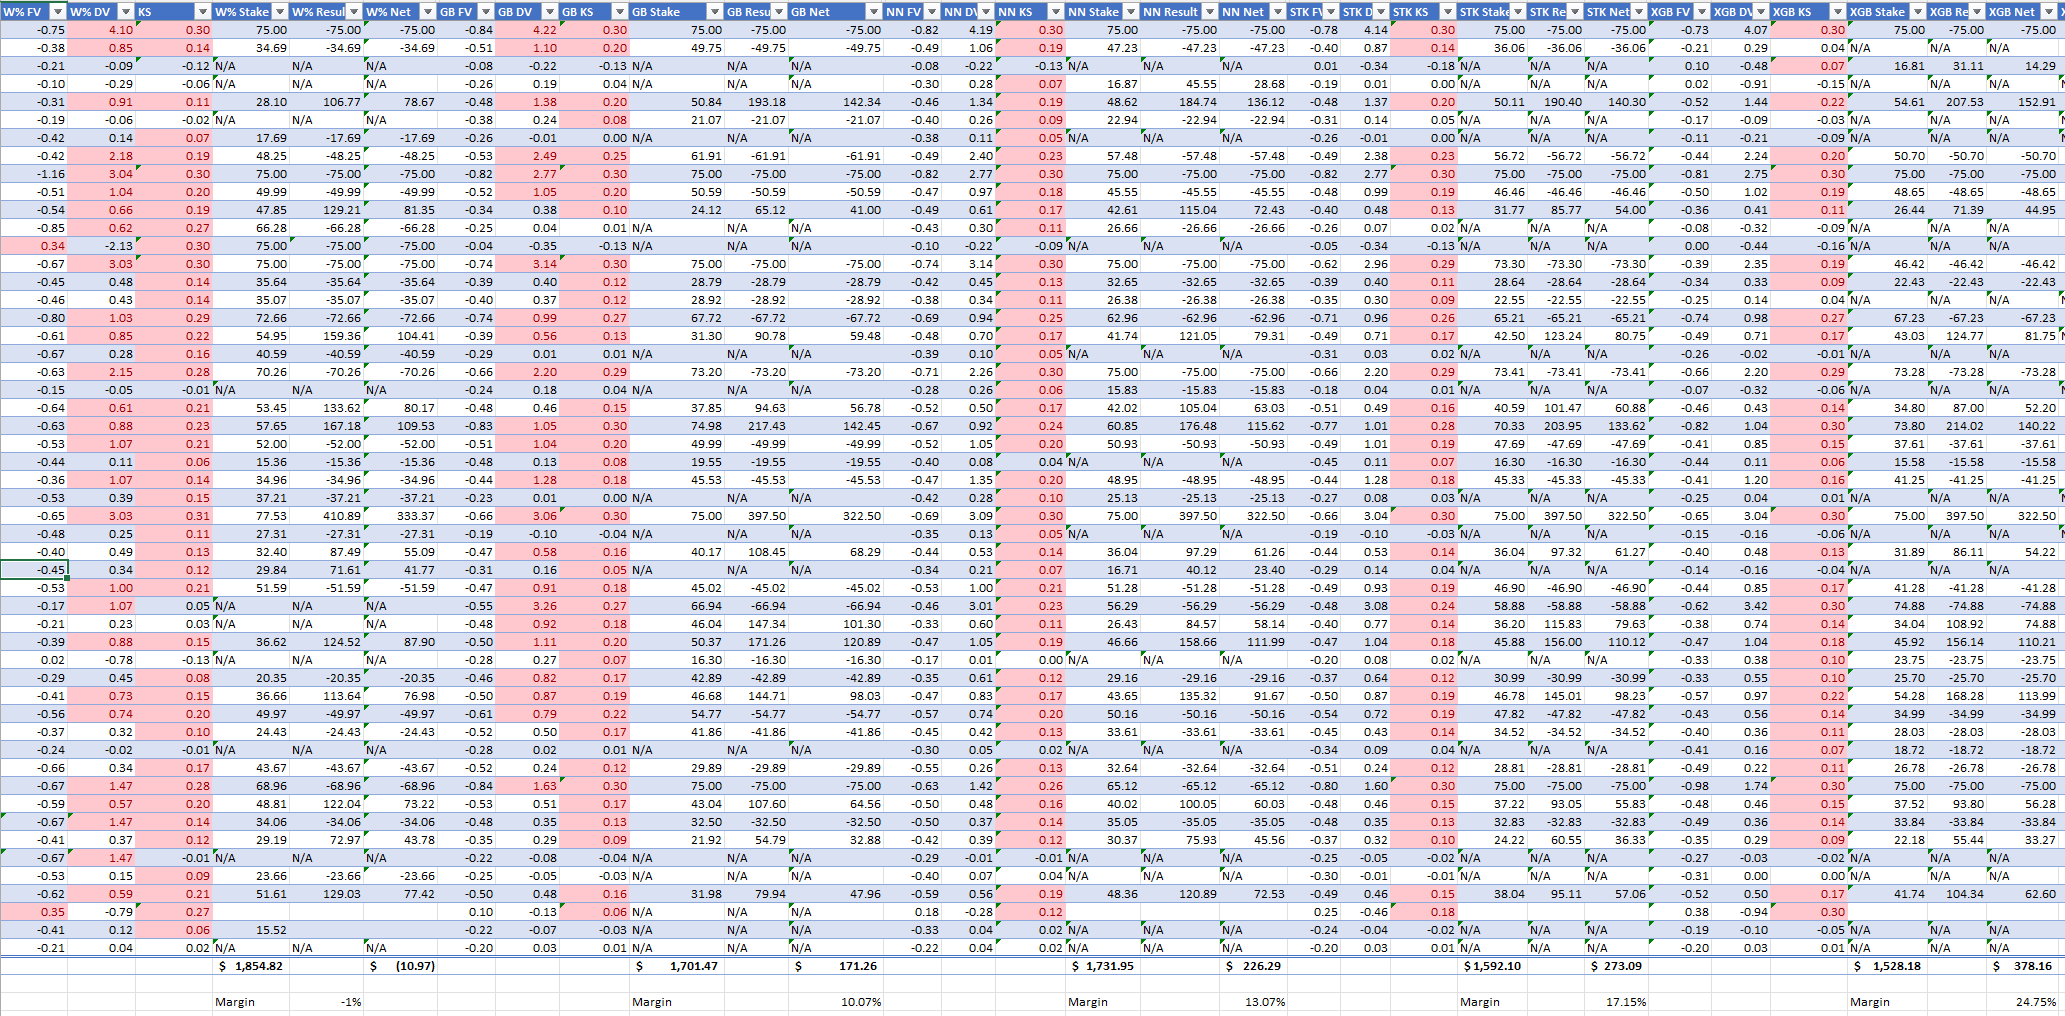

Summary Statistics:
     Model        Net                   KS          
                 mean        std      mean       std
0       GB   4.757255  86.614866  0.135500  0.114601
1   LinReg  -0.545920  79.465296  0.144437  0.108661
2       NN   5.802265  81.153288  0.142329  0.097471
3  Stacked   8.032095  86.787924  0.126941  0.113484
4      XGB  10.804487  85.225666  0.112295  0.123281


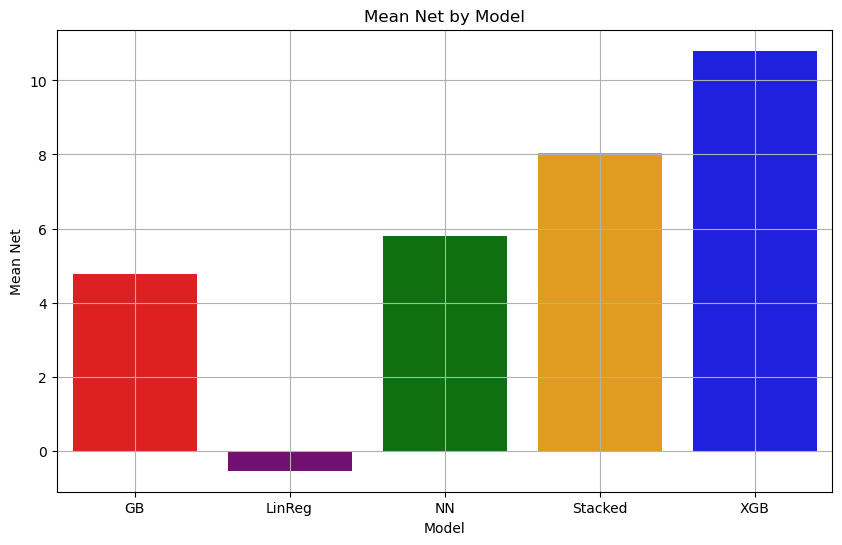

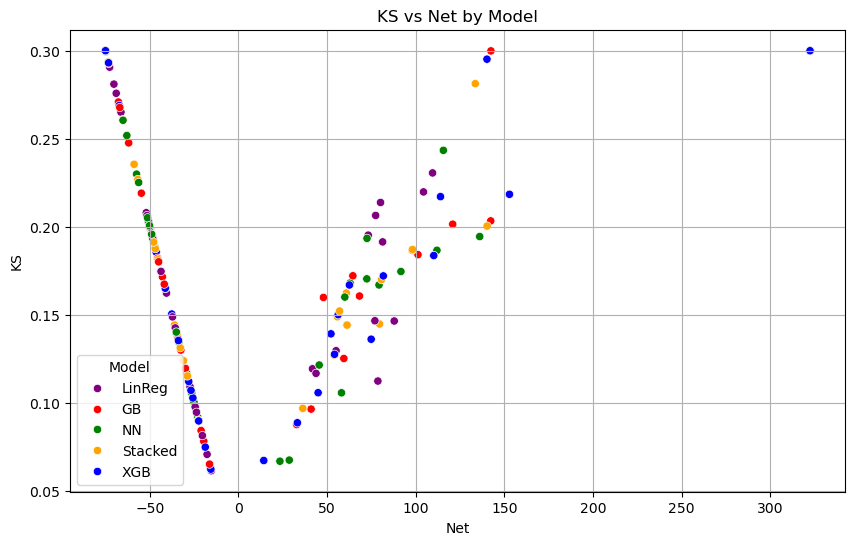

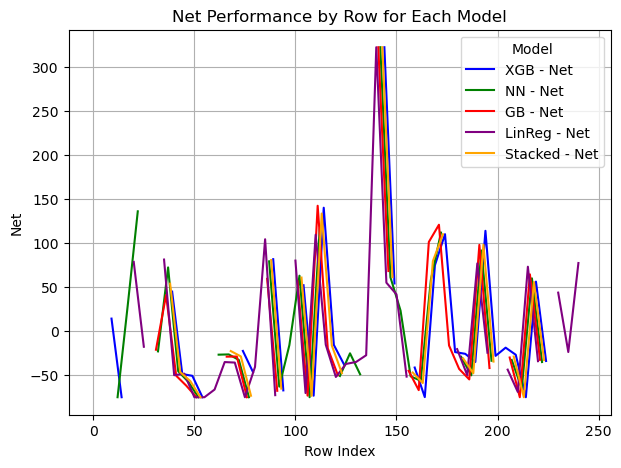

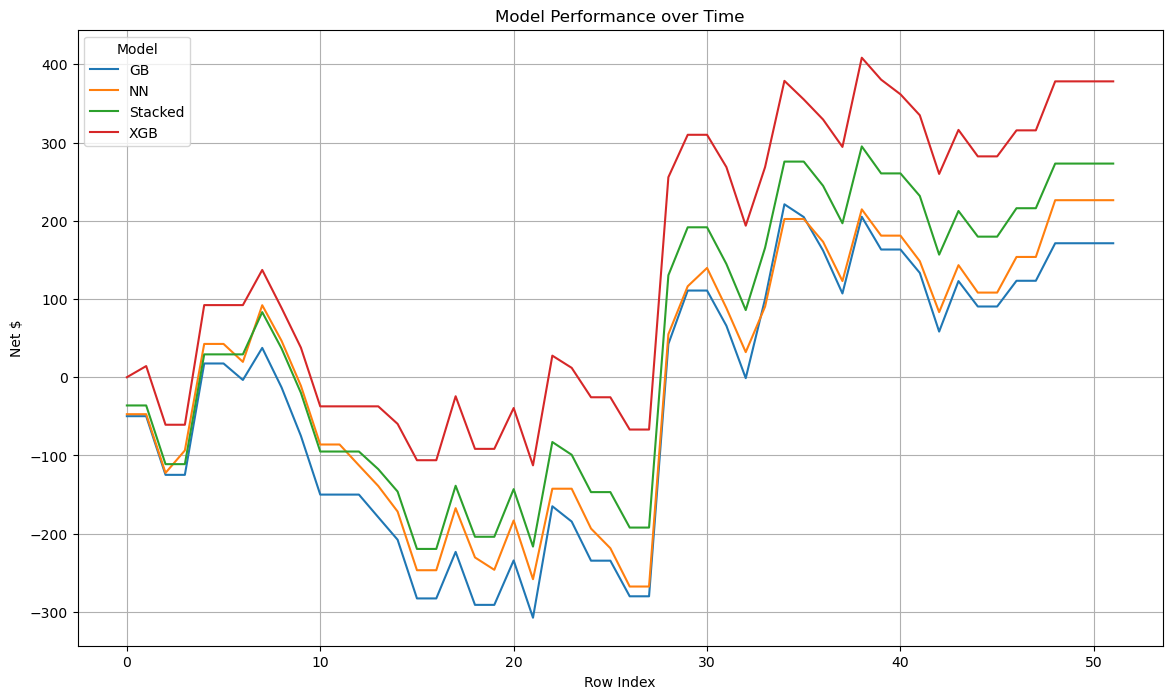

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original data from a CSV file
file_path = r"C:\Users\sahrw\OneDrive\Desktop\Summary_8_27.csv"
df = pd.read_csv(file_path)

# Convert columns to appropriate data types
df['Stake'] = pd.to_numeric(df['Stake'], errors='coerce')
df['Net'] = pd.to_numeric(df['Net'], errors='coerce')
df['KS'] = pd.to_numeric(df['KS'], errors='coerce')

# Summary statistics table
summary_stats = df.groupby('Model').agg({
    'Net': ['mean', 'std'],
    'KS': ['mean', 'std']
}).reset_index()

print("Summary Statistics:")
print(summary_stats)

# Define colors for the models
model_colors = {
    'XGB': 'blue',
    'NN': 'green',
    'GB': 'red',
    'LinReg': 'purple',
    'Stacked': 'orange'
}

# Bar plot for Mean Net by Model
mean_net = df.groupby('Model')['Net'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_net, x='Model', y='Net', hue='Model', palette=model_colors, legend=False)
plt.title('Mean Net by Model')
plt.xlabel('Model')
plt.ylabel('Mean Net')
plt.grid(True)
plt.show()

# Scatter plot for KS vs Net by Model
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Net', y='KS', hue='Model', palette=model_colors)
plt.title('KS vs Net by Model')
plt.xlabel('Net')
plt.ylabel('KS')
plt.legend(title='Model', loc='best')
plt.grid(True)
plt.show()

# Line chart for Net performance by row for each model
plt.figure(figsize=(7, 5))
for model, color in model_colors.items():
    model_df = df[df['Model'] == model].sort_index()
    plt.plot(model_df.index, model_df['Net'], label=f'{model} - Net', color=color)

plt.title('Net Performance by Row for Each Model')
plt.xlabel('Row Index')
plt.ylabel('Net')
plt.legend(title='Model')
plt.grid(True)
plt.show()

# Load the new data from the additional CSV file
new_file_path = r"C:\Users\sahrw\OneDrive\Desktop\Summary2_8_27.csv"
df_new = pd.read_csv(new_file_path, header=None)  # Read without header

# Set the first row as the header and drop it from the data
df_new.columns = df_new.iloc[0]  # Use the first row as header
df_new = df_new[1:].reset_index(drop=True)

# Clean and convert columns to numeric values
for column in df_new.columns[1:]:
    # Remove unwanted characters (e.g., parentheses, dollar signs, extra spaces)
    df_new[column] = df_new[column].replace({r'[\$,()]': '', r'\s+': ''}, regex=True)
    # Convert to numeric
    df_new[column] = pd.to_numeric(df_new[column], errors='coerce')

# Plot the time series data with row index as X-axis
plt.figure(figsize=(14, 8))
for model in df_new.columns[1:]:
    plt.plot(df_new.index, df_new[model], label=model)

plt.title('Model Performance over Time')
plt.xlabel('Row Index')
plt.ylabel('Net $')
plt.legend(title='Model')
plt.grid(True)
plt.show()

# Data Analysis/Results

A lot to unpack here, but I copied these projected round differentials between 2 teams into excel, and used binomial distribution formulas to alter these for 3 or 5 map series.  For context, KS columns stand for kelly stake, and FV/DV stand for favorite value and underdog value. As with my past linear regression model, these models rarely found value with favorite prices, instead emphasising large odds underdogs. The row 3rd from the bottom in the excel screenshot showing model performance is in the future; I have 49 completed matches tested as of 8/27/2024. The model on the far left is the basic linear regression model. 

As you can see from these results, all of the ML models are doing quite well, with the linear regression model slightly in the red. Similar to the basic regression model, the ML models tend to emphasize wagers on underdogs. However,they are more selective, as you can see with the total stake amounts. Interestingly, the models tend to improve the more selective they are in terms of stake sizes, with the exception of GBR being less efficient than the NN thus far.

Various evalulation metrics (As of 8/27/2024)
Test RMSE:
1. Stacking (0.8504990751)
2. XGB (0.8808002718)
3. GBR (0.9024496424)
4. NN (0.9484698069)

Test R2:
1. Stacking  (0.9710354663)
2. XGB (0.9689348340)
3. GBR (0.9673889483)
4. NN (0.9637918472)

The Stacking Model has the lowest RMSE and highest R², making it appear to be the most accurate of the models. Gradient Boosting and XGBoost also show excellent performance, with NN performing well but lagging a bit behind with Test RMSE. 

Based on these evaluation metrics, it is expected for the Stacking model and XGB to be the top 2 performing models, but not in this order, and not with XGB proving to be far and away the most profitable with a nearly 25% margin. I will keep monitoring this trend.

Even considering the sample size, I am excited by the performance of the ML models, especially alongside the poor performance of the traditional linear regression model. I will keep running these models and update this notebook periodically.

Sources chatgpt, vlr.gg, https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33?gi=a7277bb955b4

Additional Context:

C:\Users\sahrw\OneDrive\Desktop\scikit_2.csv": .csv file containing historical valorant match results, matching up 2 teams side by side

C:\Users\sahrw\OneDrive\Desktop\Upcoming_val.csv: .csv file with average feature statistics of teams competiting in future matches; essential for predicting future results

